In [1]:
from Customize import JAVA_PATH, CPRD_CODE_PATH, COHORT_SAVE_PATH,MODEL_SAVE_PATH, get_symptom_medcode, get_icdcode
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['JAVA_HOME'] = JAVA_PATH
import sys 
sys.path.insert(0, CPRD_CODE_PATH)

import pyspark
import shutil
from utils.yaml_act import yaml_load
from CPRD.config.spark import spark_init, read_parquet
import pyspark.sql.functions as F
from pyspark.sql import Window
from CPRD.functions import tables, modalities
from CPRD.functions import predictor_extractor
from CPRD.config.spark import read_txt, read_parquet
from CPRD.functions import merge
from utils.utils import save_obj, load_obj, create_folder
from CPRD.functions.cohort_select import Cohort
from CPRD.base.table import Diagnosis
import pandas as pd
import numpy as np
import itertools
from argparse import ArgumentParser
import logging
from pyspark.sql import Window

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


args_ = dotdict({'params': os.path.join(CPRD_CODE_PATH, 'config','config.yaml')})
params = yaml_load(args_.params)   
spark_params = params['pyspark']
spark = spark_init(spark_params)
file = params['file_path']
data_params = params['params']
pheno_dict = load_obj(file['PhenoMaps'])


In [2]:
parser = ArgumentParser()
parser.add_argument("--disease", type=str, default='AD')
parser.add_argument("--ukb_dir", type=str, default='UKB_AD_data')
parser.add_argument("--experient_dir", type=str, default='AD')
parser.add_argument("--model_name", type=str, default='cl_maskage_b32')
parser.add_argument("--stage", type=str, default='before')
parser.add_argument("--seed", type=int, default=2024)
parser.add_argument("--follow_up_year", type=int, default=5)
parser.add_argument("--k", type=int, default=5)

args = parser.parse_args([])
stage = args.stage
ukb_path = os.path.join(COHORT_SAVE_PATH, args.ukb_dir+'_'+args.stage)
experient_dir = os.path.join(MODEL_SAVE_PATH, args.experient_dir)
model_save_dir = os.path.join(experient_dir, args.model_name+'_'+stage)
results_dir = os.path.join(model_save_dir, 'results')
results_save_dir = os.path.join(results_dir, f'{args.disease}-{args.k}')


In [3]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statannotations.Annotator import Annotator

In [4]:
prs_save_dir = os.path.join(results_save_dir, 'genetic_analyses')
if not os.path.exists(prs_save_dir):
    os.makedirs(prs_save_dir)

In [6]:
result_df = pd.read_pickle(os.path.join(results_save_dir, 'result_df_'+stage+'_EHR_UKB.pkl'))
prs = pd.read_csv('adpd_snps.raw', delim_whitespace=True)
prs.rename(columns={'FID':'patid'}, inplace=True)
prs['rs429358_C'].value_counts()

0.0    296223
1.0    108371
2.0      9874
Name: rs429358_C, dtype: int64

In [7]:
ad_snp = ['rs429358_C', 'rs7412_T', 'rs143332484_T', 'rs3764650_G', 'rs3752246_G']
# APEO4, APEO2, TREM2, ABCA7, ABCA7 
pd_snp =['rs34424986_A', 'rs34637584_A', 'rs2230288_T']
# PRKN, LRRK2,GBA1 (E326K)
prs['patid'] = prs['patid'].astype(str)
prs = prs[[*['patid'], *ad_snp]]
new_df = prs.merge(result_df[['patid', 'label', 'age','Sex']], on='patid', how='inner')

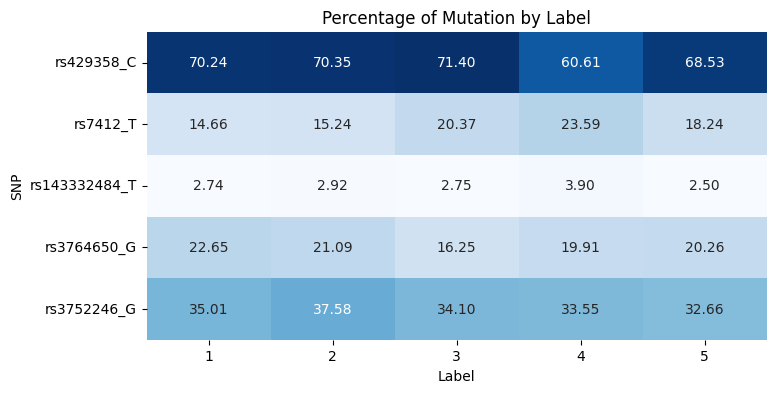

In [9]:
# Group by the 'label' column and calculate percentage nonzero for each SNP column
# The .ne(0) method creates a boolean Series that is True when the value is not 0.
grouped = new_df.groupby('label')

# Create an empty dictionary to collect the percentages for each label
results = {}
for label, group in grouped:
    # For each SNP, calculate the percentage of non-zero entries in the group
    percents = {snp: (group[snp].astype(float).ne(0).sum() / len(group)) * 100 
                for snp in ad_snp}
    results[label] = percents

# Convert the dictionary to a DataFrame.
# Rows will be SNPs, columns will be label values (1 through 5)
heatmap_data = pd.DataFrame(results)
# Optionally, sort the columns (if needed) to ensure labels appear in order
heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data,cmap='Blues', annot=True, fmt=".2f", 
            annot_kws={"size": 10},  # Increase font size of the cell values
            cbar=False,  # Remove the color bar
            xticklabels=True, yticklabels=True)

plt.xlabel('Label')
plt.ylabel('SNP')
plt.title('Percentage of Mutation by Label')
plt.savefig(os.path.join(prs_save_dir, 'snp_heatmap.png'))
plt.show()

In [9]:
ad_prs = ['rs429358_C', 'rs7412_T', 'rs143332484_T', 'rs3764650_G', 'rs3752246_G']
normal_values = {
    'rs429358_C': 0.06817,
    'rs7412_T': 0.082919,
    'rs143332484_T': 0.010499,
    'rs3764650_G': 0.093706,
    'rs3752246_G': 0.17085,
}


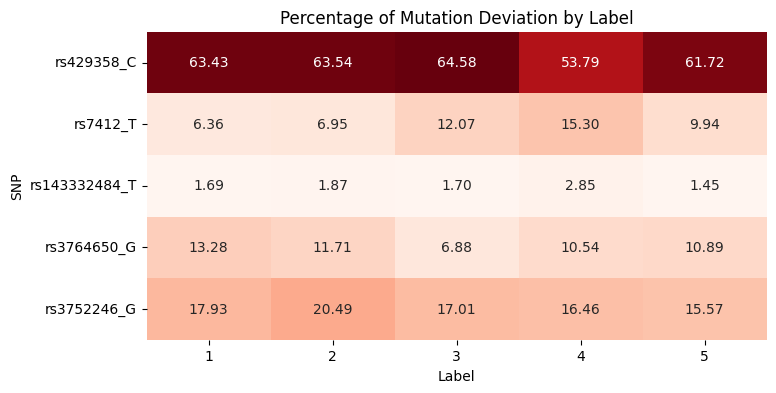

In [11]:
# Group by the 'label' column and calculate percentage nonzero for each SNP column
# The .ne(0) method creates a boolean Series that is True when the value is not 0.
grouped = new_df.groupby('label')

# Create an empty dictionary to collect the percentages for each label
results = {}
for label, group in grouped:
    # For each SNP, calculate the percentage of non-zero entries in the group
    percents = {snp: (group[snp].astype(float).ne(0).sum() / len(group)) * 100 - normal_values[snp]*100
                for snp in ad_prs}
    results[label] = percents

# Convert the dictionary to a DataFrame.
# Rows will be SNPs, columns will be label values (1 through 5)
heatmap_data = pd.DataFrame(results)

# Optionally, sort the columns (if needed) to ensure labels appear in order
heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data,cmap='Reds', annot=True, fmt=".2f", 
            annot_kws={"size": 10},  # Increase font size of the cell values
            cbar=False,  # Remove the color bar
            xticklabels=True, yticklabels=True)

plt.xlabel('Label')
plt.ylabel('SNP')
plt.title('Percentage of Mutation Deviation by Label')
plt.savefig(os.path.join(prs_save_dir, 'snp_Deviation_heatmap.png'))
plt.show()

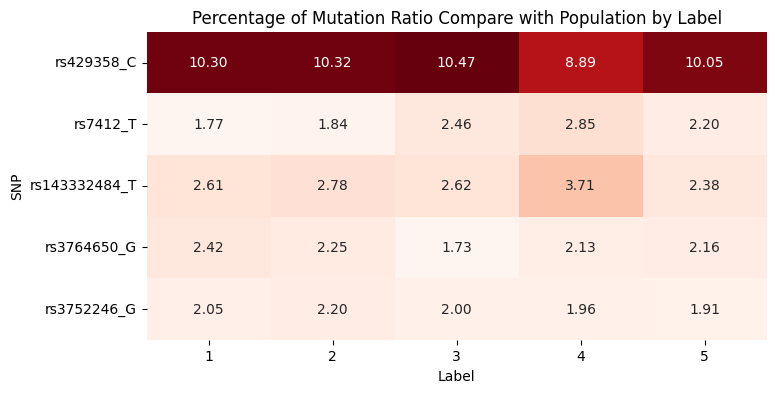

In [11]:
grouped = new_df.groupby('label')

# Create an empty dictionary to collect the percentages for each label
results = {}
for label, group in grouped:
    # For each SNP, calculate the percentage of non-zero entries in the group
    percents = {snp: (group[snp].astype(float).ne(0).sum() / len(group)) / normal_values[snp]
                for snp in ad_prs}
    results[label] = percents

# Convert the dictionary to a DataFrame.
# Rows will be SNPs, columns will be label values (1 through 5)
heatmap_data = pd.DataFrame(results)

# Optionally, sort the columns (if needed) to ensure labels appear in order
heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)

# Plot the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(heatmap_data,cmap='Reds', annot=True, fmt=".2f", 
            annot_kws={"size": 10},  # Increase font size of the cell values
            cbar=False,  # Remove the color bar
            xticklabels=True, yticklabels=True)

plt.xlabel('Label')
plt.ylabel('SNP')
plt.title('Percentage of Mutation Ratio Compare with Population by Label')
plt.savefig(os.path.join(prs_save_dir, 'snp_Ratio_heatmap.png'))
plt.show()

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
import os

# Exclude 'Control' and reset index
new_df_non = new_df[new_df['label'] != 'Control'].copy()
new_df_non.reset_index(drop=True, inplace=True)

# Rename numeric labels to string labels
label_mapping = {1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 4: 'Cluster 4', 5: 'Cluster 5'}
new_df_non['label'] = new_df_non['label'].map(label_mapping)

# Define clusters (order)
clusters = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']

# Create a list to store the results
results = []

# Loop over each SNP and each cluster (compared to all others)
for snp in ad_prs:
    for cluster in clusters:
        # Select data for the current cluster and for the rest ("Other")
        group_df = new_df_non[new_df_non['label'] == cluster]
        other_df = new_df_non[new_df_non['label'] != cluster]
        
        # Calculate counts for nonzero (mutated) vs zero
        nonzero_group = group_df[snp].astype(float).ne(0).sum()
        total_group = len(group_df)
        nonzero_other = other_df[snp].astype(float).ne(0).sum()
        total_other = len(other_df)
        
        # Build the 2x2 contingency table:
        #           Mutated            Not Mutated
        # Group:    nonzero_group      total_group - nonzero_group
        # Other:    nonzero_other      total_other - nonzero_other
        table = [[nonzero_group, total_group - nonzero_group],
                 [nonzero_other, total_other - nonzero_other]]
        
        # Run Fisher's exact test (if counts allow; otherwise p_value = NaN)
        try:
            odds_ratio, p_value = fisher_exact(table)
        except Exception as e:
            p_value = np.nan
        
        # Compute the percentage of mutated samples in each group
        perc_group = (nonzero_group / total_group * 100) if total_group > 0 else np.nan
        perc_other = (nonzero_other / total_other * 100) if total_other > 0 else np.nan
        
        # Append the results as a row in the results list
        results.append({
            'SNP': snp,
            'Cluster': cluster,
            'Group_n': total_group,
            'Other_n': total_other,
            'Group_Nonzero': nonzero_group,
            'Other_Nonzero': nonzero_other,
            'Group_%': perc_group,
            'Other_%': perc_other,
            'Odds_Ratio': odds_ratio,
            'p_value': p_value
        })

# Convert the list to a DataFrame
results_df = pd.DataFrame(results)
results_df


,SNP,Cluster,Group_n,Other_n,Group_Nonzero,Other_Nonzero,Group_%,Other_%,Odds_Ratio,p_value
0,rs429358_C,Cluster 1,1351,2217,949,1504,70.244264,67.839423,1.119133,0.136510
1,rs429358_C,Cluster 2,479,3089,337,2116,70.354906,68.501133,1.091286,0.427309
2,rs429358_C,Cluster 3,437,3131,312,2141,71.395881,68.380709,1.154152,0.225475
3,rs429358_C,Cluster 4,462,3106,280,2173,60.606061,69.961365,0.660554,0.000067
4,rs429358_C,Cluster 5,839,2729,575,1878,68.533969,68.816416,0.986956,0.898355
5,rs7412_T,Cluster 1,1351,2217,198,424,14.655811,19.124944,0.726190,0.000639
6,rs7412_T,Cluster 2,479,3089,73,549,15.240084,17.772742,0.831875,0.195345
7,rs7412_T,Cluster 3,437,3131,89,533,20.366133,17.023315,1.246587,0.092250
8,rs7412_T,Cluster 4,462,3106,109,513,23.593074,16.516420,1.560763,0.000291
9,rs7412_T,Cluster 5,839,2729,153,469,18.235995,17.185782,1.074739,0.498844


In [11]:
results_df.to_csv(os.path.join(prs_save_dir, f'UKB_{args.disease}_SNP_fisher_test.csv'))